# Exact Exchange Calculations 
**by <span style="color:darkgreen">Ute Werner</span> for [<span style="color:darkgoldenrod">exciting *neon*</span>](https://www.exciting-code.org/neon)**

<font size="2">(Jupyter notebook by <span style="color:darkgreen">Mara Voiculescu</span> & <span style="color:darkgreen">Martin Kuban</span>)</font>
<hr style="border:2px solid #DDD"> </hr>

**<span style="color:firebrick">Purpose</span>**: In this tutorial, you will learn how to perform band-structure calculations using the optimized effective potential - exact-exchange (**EXX**) method. As an example, the band structure of diamond is calculated.
<hr style="border:2px solid #DDD"> </hr>

<div class="alert alert-block alert-warning">

**Table of Contents**
    
[0. Before Starting](#0)
    
[1. Introduction](#1)  
    
[2. LDA Calculation](#2)
   - Preparation of the Calculation
   - Execute the Calculation 

[3. Exact-Exchange Calculation](#3)
   - Preparation of the Input File
   - Execute the Calculation 
    
[4. Post Processing](#4)

[5. Excercise](#5)      

[6. Literature](#6)
</div>

<a id='0'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">0. Before Starting</span>

**<span style="color:firebrick">Read the following paragraphs before starting with the rest of this tutorial!</span>**

Before running any Jupyter tutorials, please refer to the **`00_before_starting.md`** document on how to correctly set up the environment. This only needs to be done once. After which, the **venv** can be (re)activated from **`exciting`**'s root directory:

<div style="background-color: rgb(224, 224, 224);">

```bash
source tools/excitingjupyter/venv/excitingvenv/bin/activate
```

</div>

As a first step, you may create a running directory for the notebook.

In [1]:
%%bash
mkdir -p run_tutorial_exact_exchange_calculations

<a id='1'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">1. Introduction</span>

A typical exact exchange (**EXX**) calculation consists of two parts. Initially a ground state self-consistent cycle, for example with **LDA**, is performed to create good Kohn-Sham orbitals as initial guess for the **EXX** calculation. Afterwards, starting from these data, a self consistent **EXX** calculation is executed.

<a id='2'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">2. LDA Calculation</span>

We start by performing an **LDA** calculation for comparing with **EXX**. This initial **LDA** calculation is not related to the initial self-consistent cycle performed at the beginning of the **EXX** calculation, since the latter is done internally by **`exciting`**.

As usual, the first thing to do is to create the subdirectory for the **LDA** calculation.

In [2]:
%%bash
cd run_tutorial_exact_exchange_calculations
mkdir -p LDA
cd ..

#### <span style="color:#15317E">i) Preparation of the Calculaion</span>

Create an input file input.xml for the ground-state and band-structure calculation of diamond using LDA which could look like this

<span class="DIAMOND_LDA"></span>
```xml
<input>
 
   <title>Diamond LDA</title>
 
   <structure speciespath="$EXCITINGROOT/species" >
      <crystal scale="6.7425">
         <basevect> 0.0     0.5     0.5 </basevect>
         <basevect> 0.5     0.0     0.5 </basevect>
         <basevect> 0.5     0.5     0.0 </basevect>
      </crystal>
      <species speciesfile="C.xml">
         <atom coord="0.00 0.00 0.00" />
         <atom coord="0.25 0.25 0.25" />
      </species>
   </structure>
 
   <groundstate 
      ngridk="8 8 8"
      xctype="LDA_PW">
   </groundstate>
 
   <properties>
      <bandstructure>
         <plot1d>
            <path steps="200">
               <point coord="1.0     0.0     0.0" label="Gamma"/>
               <point coord="0.625   0.375   0.0" label="K"/>
               <point coord="0.5     0.5     0.0" label="X"/>
               <point coord="0.0     0.0     0.0" label="Gamma"/>
               <point coord="0.5     0.0     0.0" label="L"/> 
            </path>
         </plot1d>
      </bandstructure>
   </properties>
 
</input>
```

This can be done by writing the complete input as a string and saving it in your working directory as **input.xml**.

In [4]:
import os
from excitingjupyter.utilities import get_input_xml_from_notebook   

# Extract input file content from this notebook:
input_str_LDA = get_input_xml_from_notebook("06_tutorial_exact_exchange_calculations", "DIAMOND_LDA")

# Write out the input as an XML file:
with open('./run_tutorial_exact_exchange_calculations/LDA/input.xml', "w") as fid:
    fid.write(input_str_LDA)

We assume you are already familiar with band-structure calculations. However, if you need information on the meaning of the different arguments and keywords inside the element <code><span style="color:green">properties</span></code>, you can have a look to the tutorial **Electronic band-structure and density of states**.

**Be sure** to set the correct path for the **`exciting`** root directory (indicated in this example by **$EXCITINGROOT**) to the one pointing to the place where the **`exciting`** directory is placed. In order to do this, use the following command:

In [5]:
%%bash
cd run_tutorial_exact_exchange_calculations/LDA
python3 -m excitingscripts.setup.excitingroot
cd ../..

#### <span style="color:#15317E">ii) Execute the Calculation</span>

Perform the **LDA** calculation using the script **`excitingscripts.execute.single`**.

In [13]:
%%bash
cd run_tutorial_exact_exchange_calculations
python3 -m excitingscripts.execute.single -r LDA
cd ..

**Be sure** that your calculation is completed before proceeding with the next steps!

<a id='3'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">3. Exact-Exchange Calculation</span>

#### <span style="color:#15317E">i) Preparation of the Calculaion</span>

In the next step, we will calculate the ground state and band structure using **EXX**. Therefore, replace the <code><span style="color:green">groundstate</span></code>  section in the file **input.xml** with the following lines.

```xml
...
   <groundstate 
      ngridk="3 3 3"
      xctype="EXX"
      vkloff="0.5 0.5 0.5"
      nempty="29">
 
      <OEP 
         maxitoep="100"> 
      </OEP>
 
   </groundstate>
...

```

In [16]:
%%bash
cd run_tutorial_exact_exchange_calculations
mkdir -p EXX
cd ..

In [19]:
# The following lines modify the input.xml using Python
groundstate_EXX = """<groundstate 
      ngridk="3 3 3"
      xctype="EXX"
      vkloff="0.5 0.5 0.5"
      nempty="29">
 
      <OEP 
         maxitoep="100"> 
      </OEP>
      
     </groundstate>
"""

index1=input_str_LDA.find("<groundstate")
index2=input_str_LDA.find("<properties>")

input_str_EXX = input_str_LDA[:index1] + groundstate_EXX +"\n"+ input_str_LDA[index2:]

with open('./run_tutorial_exact_exchange_calculations/EXX/input.xml', "w") as fid:
    fid.write(input_str_EXX)

In [20]:
%%bash
cd run_tutorial_exact_exchange_calculations/EXX
python3 -m excitingscripts.setup.excitingroot
cd ../..

Let's have a closer look at the parameters in this file.

Parameter|Description
:-----------|:--------------------------------
<code><span style="color:mediumblue">xctype</span></code>=**"EXX"**|The calculation is performed using the exact-exchange functional.
<code><span style="color:mediumblue">nempty</span></code>=**"29"**|The number of empty bands, crucial for the convergence.
<code><span style="color:mediumblue">vkloff</span></code>=**"0.5 0.5 0.5"**|The origin of the k-point grid, crucial for the convergence.
<code><span style="color:mediumblue">maxitoep</span></code>=**"100"**|The number of iterations for the evaluation of integrals in **EXX**.

Since the **EXX** calculations are much more time consuming than corresponding **LDA** ones, computational parameters have been chosen in a way to speed up the calculation. However, the calculation will still last approximately 10-20 min. For further details on the parameters see [**Input Reference**](http://exciting.wikidot.com/ref:input).

#### <span style="color:#15317E">ii) Execute the Calculation</span>

In [ ]:
%%bash
cd run_tutorial_exact_exchange_calculations
python3 -m excitingscripts.execute.single -r EXX
cd ..

<a id='4'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">4. Post Processing</span>



For a graphical comparison of the band structures calculated with the **LDA** and **EXX** functionals you can use the script **`excitingscripts.plot.band_structure`**, which is fully described in [**The python script "plot.band_structure"**](https://www.exciting-code.org/the-python-script-plot.band_structure). Move to the parent directory (the one where you can find the **LDA** and **EXX** subdirectories) and execute the script as follows.

In [22]:
%%bash
cd run_tutorial_exact_exchange_calculations
python3 -m excitingscripts.plot.band_structure -d LDA EXX  -e -25 25  -z vbM  -l 'lower right'
cd ..

<figure>
<img src=" 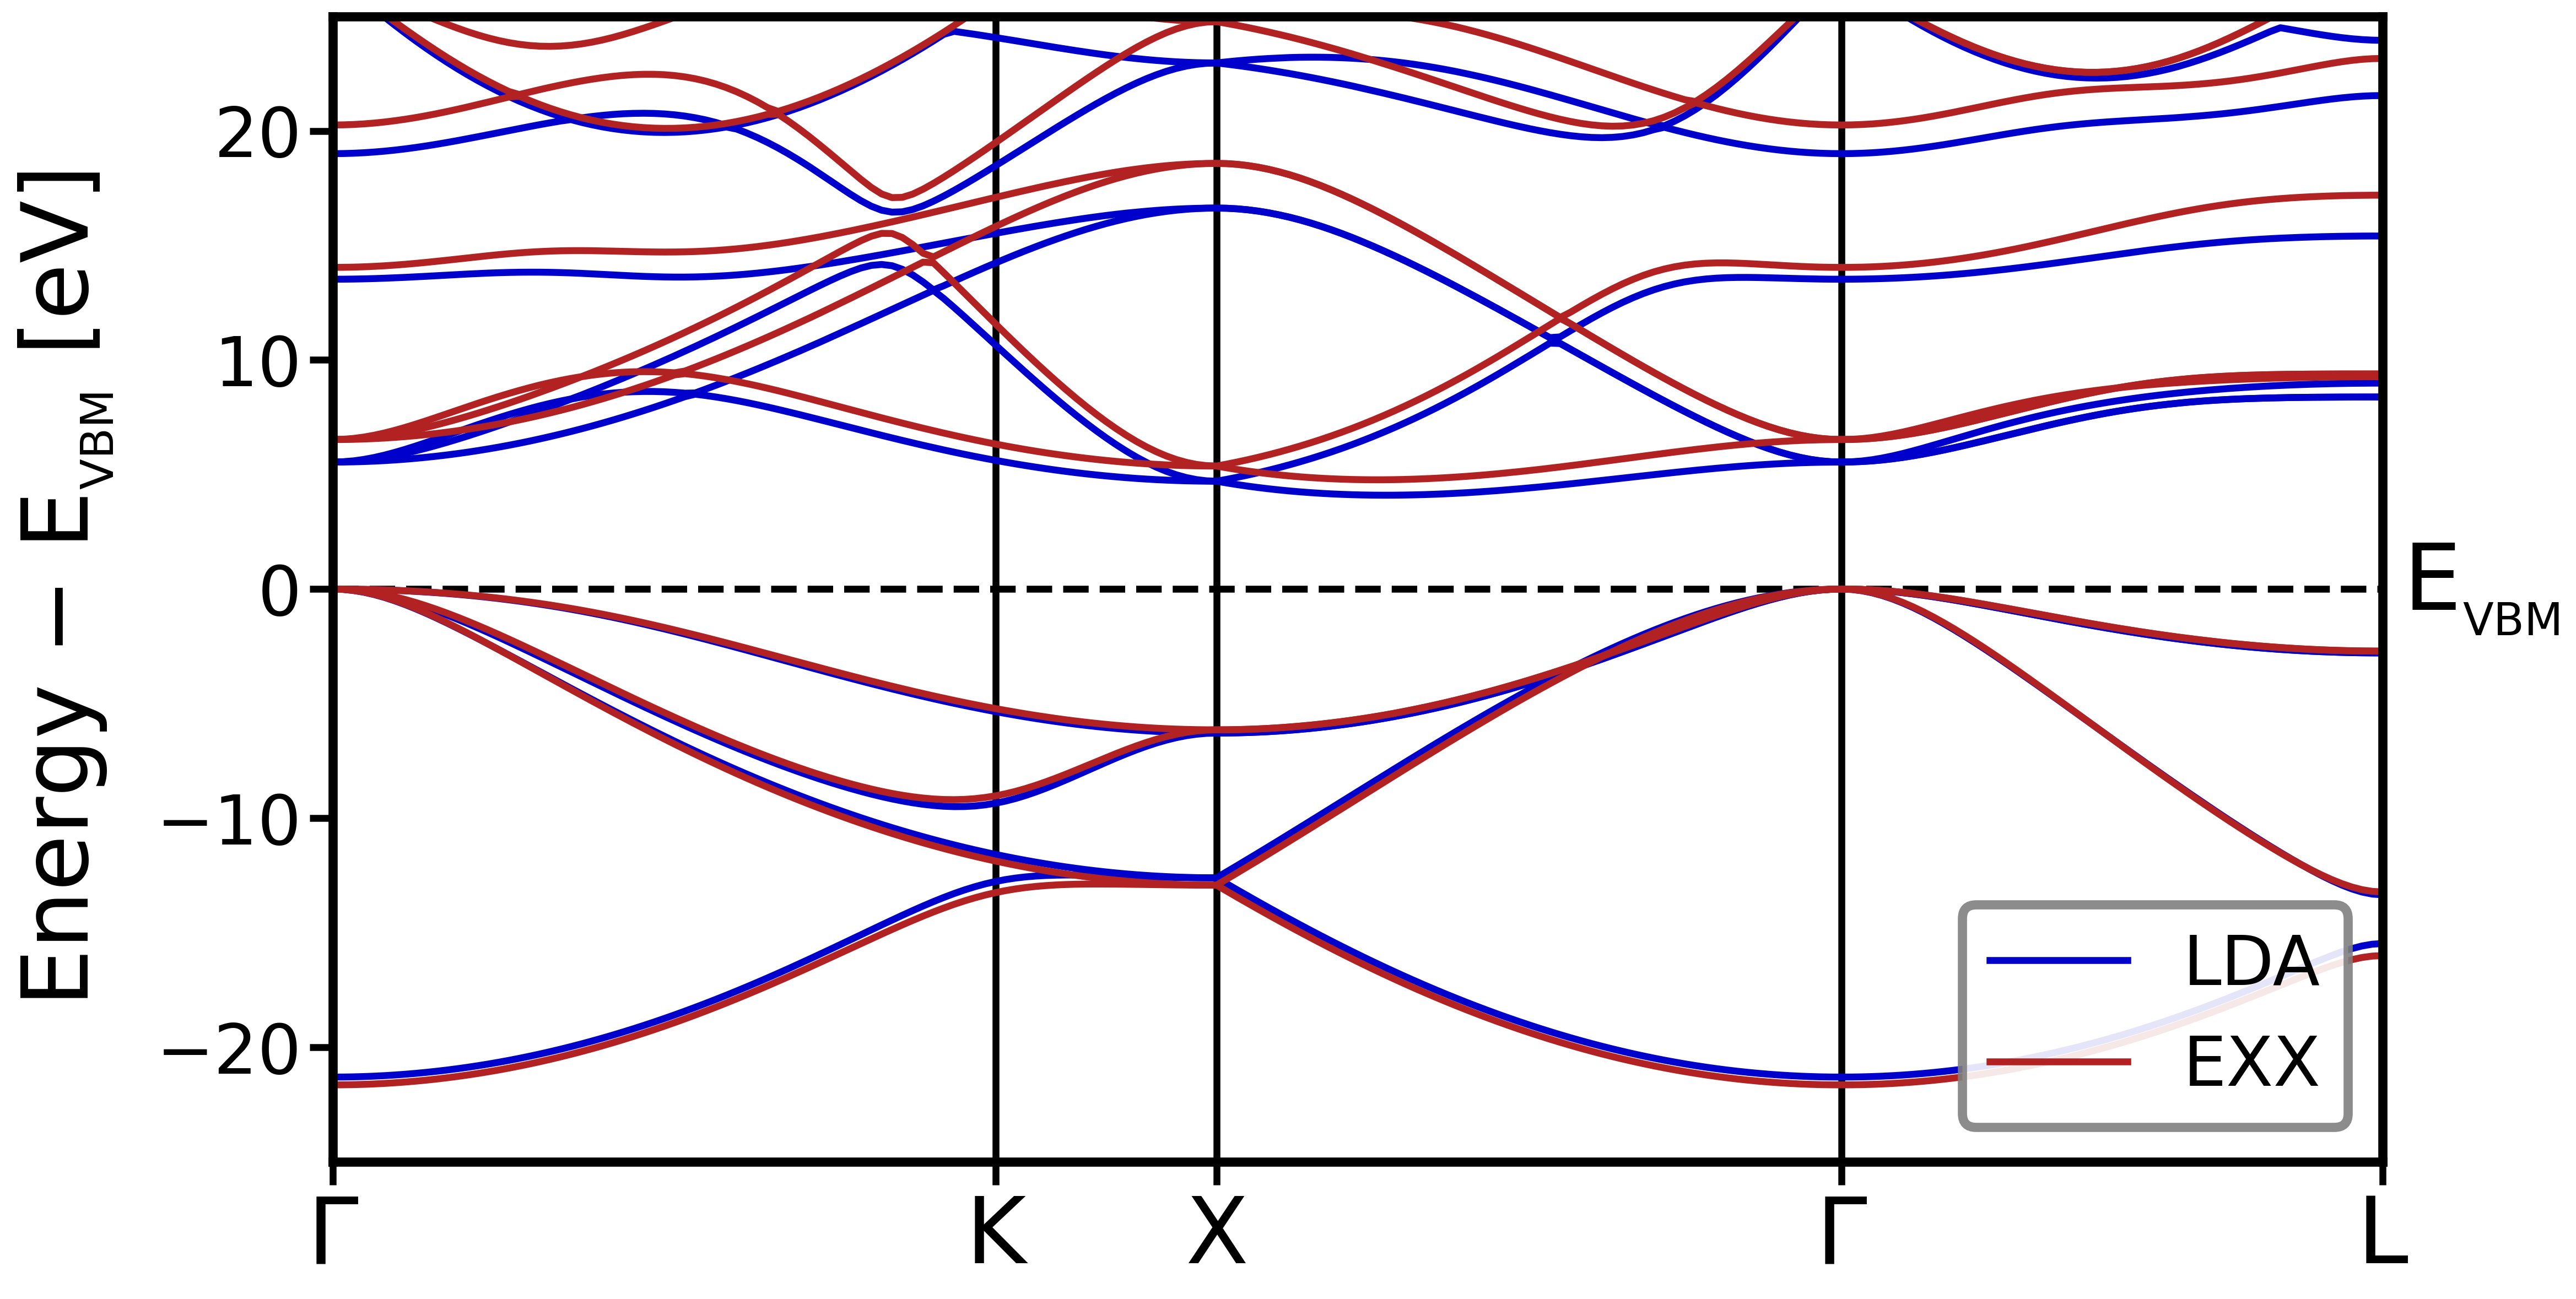" width="600" align="left"/>
</figure>

<a id='5'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">5. Excercise</span>

Try to modify some of the parameters in the <code><span style="color:green">groundstate</span></code> element of the **EXX** input file and investigate the effect on the band structure and on the computational time.

<a id='6'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">6. Literature</span>

- S. Sharma, J. K. Dewhurst, and C. Ambrosch-Draxl, Phys. Rev. Lett. **95**, 136402 (2005); S. Sharma, J. K. Dewhurst, C. Ambrosch-Draxl, S. Kurth, N. Helbig, S. Pittalis, S. Shallcross, L. Nordström, and E. K. U. Gross, Phys. Rev. Lett. **98**, 196405 (2007)

<hr style="border:2px solid #DDD"> </hr>